# Dependencies

In [ ]:
!pip install pyhdf h5py pytorch-ignite PyWavelets -q # TIMM models

import PIL
import numpy as np
import sys
import random
import torch
from torch.nn.functional import interpolate
from torchvision import transforms
from torchvision.transforms import functional as ttf
import numbers
import cv2
from tqdm import tqdm
from pyhdf.SD import SD, SDC
from h5py import File as h5File
import pywt as pywt

import matplotlib.pyplot as plt
from mrunet import *
from zssrnet import *
from swinir import *

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.metrics.regression import *
from ignite.utils import *

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.6/771.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [ ]:
class TensorRandomRotationFromSequence(object):
    def __init__(self, degree):
        self.degrees = degrees

    @staticmethod
    def get_params(degrees):
        angle = np.random.choice(degrees)
        return angle
    def __call__(self, collapsed):
        angle = self.get_params(self.degrees)
        return ttf.rotate(collapsed, angle)

class RandomRotationFromSequence(object):
    """Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
    """

    def __init__(self, degrees):
        self.degrees = degrees

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.choice(degrees)
        return angle

    def __call__(self, data):
        """img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """
        angle = self.get_params(self.degrees)
        try: # as in original implementation
            hr, lr = data
            return ttf.rotate(hr, angle), ttf.rotate(lr, angle)
        except: # if you are providing a tensor
            return ttf.rotate(data, angle)

class RandomHorizontalFlip(object):
    """Horizontally flip the given PIL Image randomly with a probability of 0.5."""

    def __call__(self, data):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        hr, lr = data
        if random.random() < 0.5:
            return ttf.hflip(hr), ttf.hflip(lr)
        return hr, lr

class RandomVerticalFlip(object):
    """Vertically flip the given PIL Image randomly with a probability of 0.5."""

    def __call__(self, data):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        hr, lr = data
        if random.random() < 0.5:
            return ttf.vflip(hr), ttf.vflip(lr)
        return hr, lr

class RandomCrop(object):
    """Crop the given PIL Image at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is 0, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively.
    """

    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    @staticmethod
    def get_params(data, output_size):
        """Get parameters for ``crop`` for a random crop.
        Args:
            img (PIL Image): Image to be cropped.
            output_size (tuple): Expected output size of the crop.
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
        """
        hr, lr = data
        _, _,h, w = hr.shape
        th, tw = output_size
        if w == tw or h == th:
            return 0, 0, h, w

        if w < tw or h < th:
            th, tw = h//2, w//2

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, data):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            PIL Image: Cropped image.
        """
        try:
            hr, lr = data
        except:
            hr = data[0, :,:,:].unsqueeze(0)
            lr = data[1, :,:,:].unsqueeze(0)

        if self.padding > 0:
            hr = ttf.pad(hr, self.padding)
            lr = ttf.pad(lr, self.padding)

        i, j, h, w = self.get_params(data, self.size)
        return ttf.crop(hr, i, j, h, w), ttf.crop(lr, i, j, h, w)

class ToTensor(object):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """

    def __call__(self, data):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        hr, lr = data
        return ttf.to_tensor(hr), ttf.to_tensor(lr)

# General Utils
def adjust_learning_rate(optimizer, new_lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

# Evaluator for SSIM
def eval_step(engine, batch):
    return batch

'''
class CustomSSIM:
    """SSIM stimated by torch.ignite"""
    def __init__(self, evaluator):
        self.name="SSIM"
        self.evaluator = self.evaluator
        self.metric = SSIM(data_range=1.0)
        self.metric.attach(self.evaluator, "ssim")
    def __call__(self, lr, hr):
        state = self.evaluator.run([[lr, hr]])
        return state.metrics["ssim"]
 '''

class CustomSSIM(torch.nn.Module):
    """SSIM stimated by torch.ignite"""
    def __init__(self, evaluator):
        super(CustomSSIM, self).__init__()
        self.name="SSIM"
        self.evaluator = evaluator
        self.metric = SSIM(data_range=1.0)
        self.metric.attach(self.evaluator, "ssim")
    def forward(self, lr, hr):
        state = self.evaluator.run([[lr, hr]])
        return torch.Tensor([1 - state.metrics["ssim"]])

'''
class PSNR: #### check out img range for grayscale [0,1]
    """Peak Signal to Noise Ratio"""
    def __init__(self):
        self.name = "PSNR"
    @staticmethod
    def __call__(img1, img2):
        mse = torch.mean((img1 - img2) ** 2)
        return (20 * torch.log10(255.0 / torch.sqrt(mse))).item()
'''
class PSNR(torch.nn.Module):
    def __init__(self):
        super(PSNR, self).__init__()
        self.name = "PSNR"
    def forward(self, img1, img2):
        mse = torch.mean((img1 - img2) ** 2)
        return -(20 * torch.log10(1.0 / torch.sqrt(mse)))

evaluator = Engine(eval_step)
psnr = PSNR()
ssim = CustomSSIM(evaluator)

x, y = torch.rand(1, 3, 64, 64), torch.rand(1,3,64,64)
m = ssim(x,x); print(m)


tensor([0.])


# Orirginal Implementation

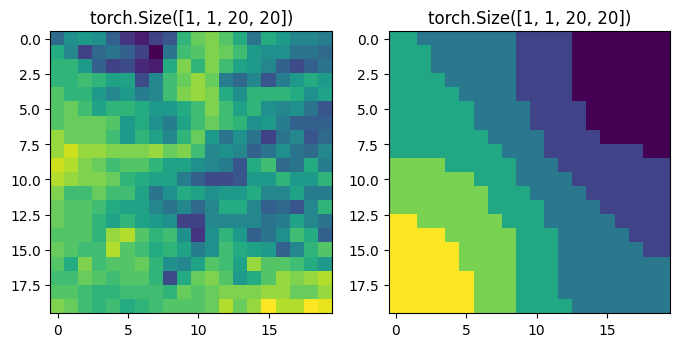

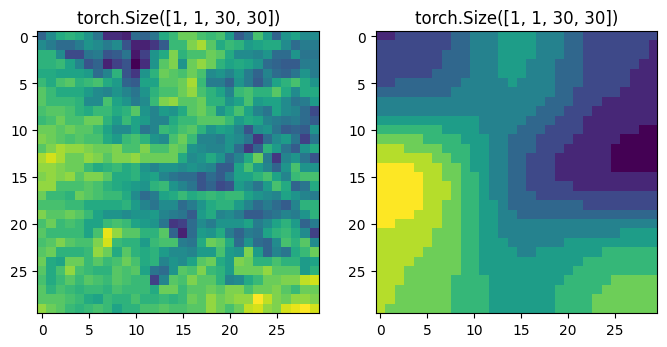

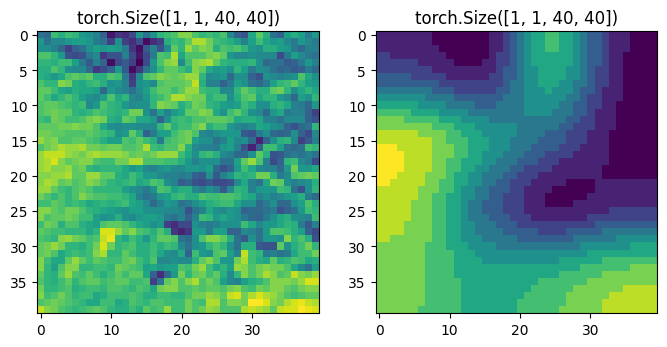

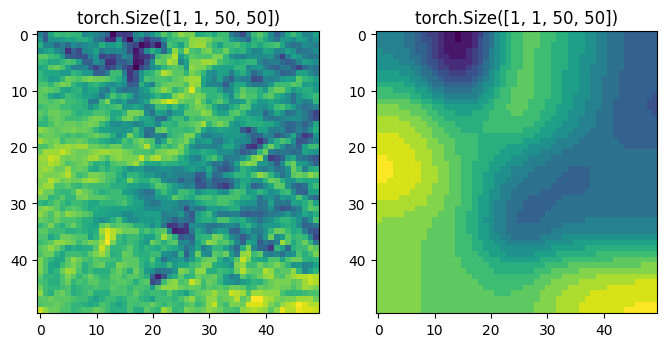

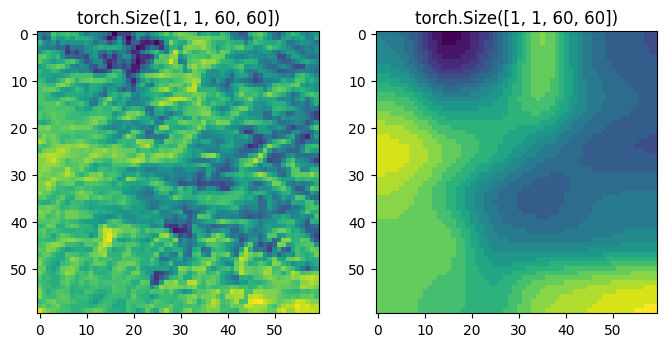

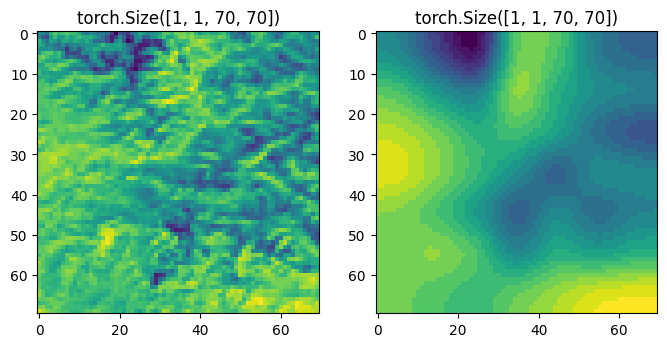

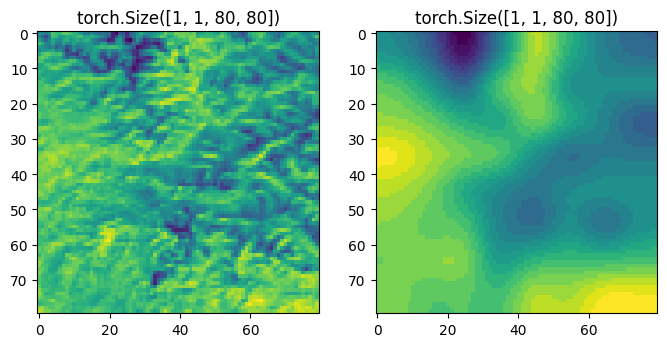

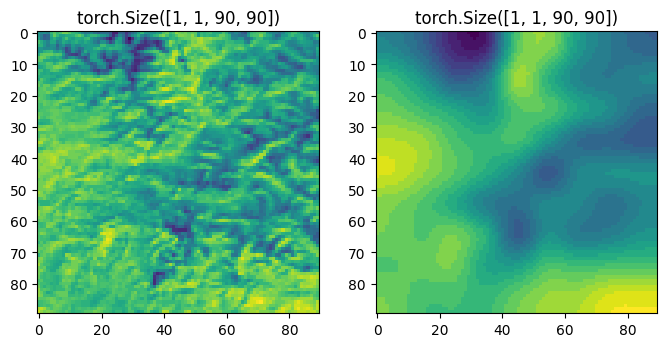

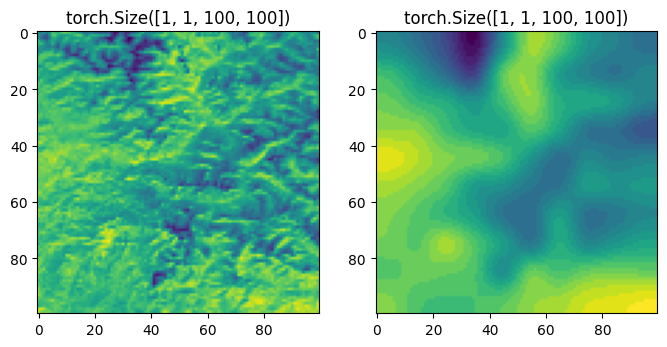

In [ ]:
for hr, lr in sampler.pairs:
    _, axs = plt.subplots(1,2,figsize=(8,4))
    axs[0].imshow(ttf.to_pil_image(hr.squeeze())); axs[0].set_title(hr.shape)
    axs[1].imshow(ttf.to_pil_image(lr.squeeze())); axs[1].set_title(lr.shape)
    plt.show()

### DataSampler, tensor implementation

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])


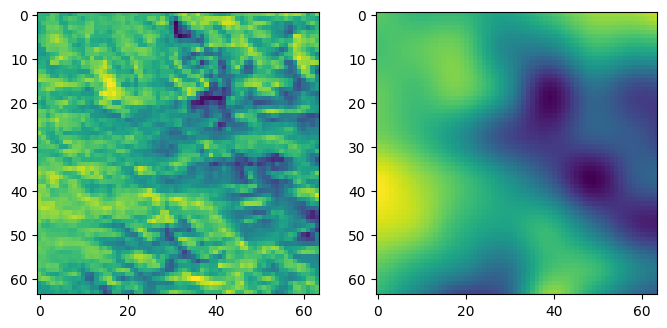

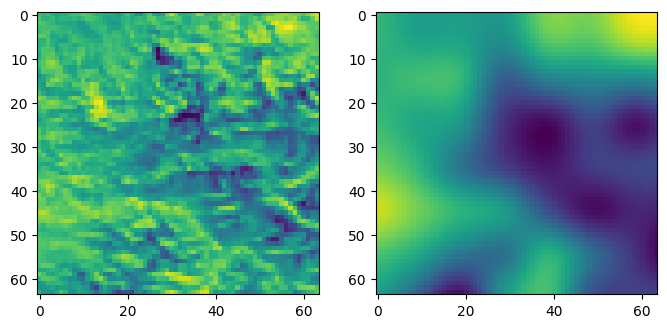

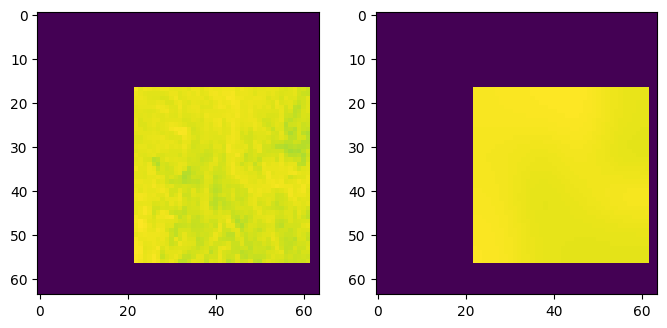

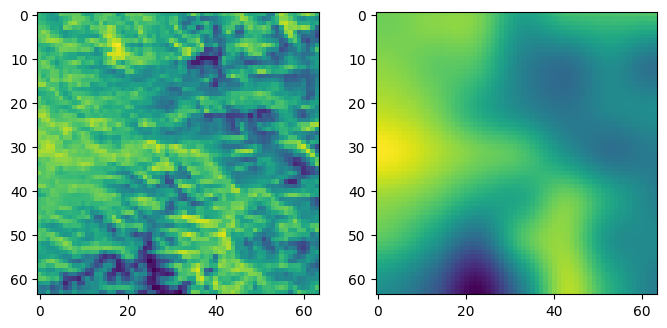

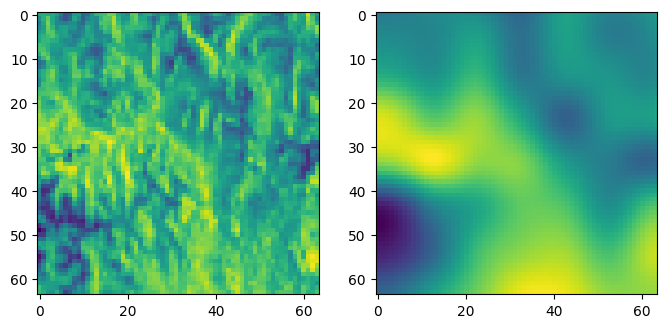

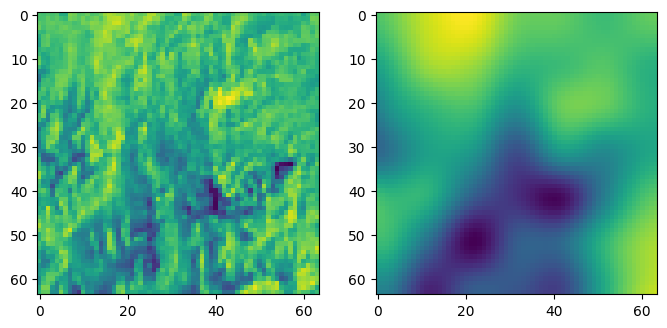

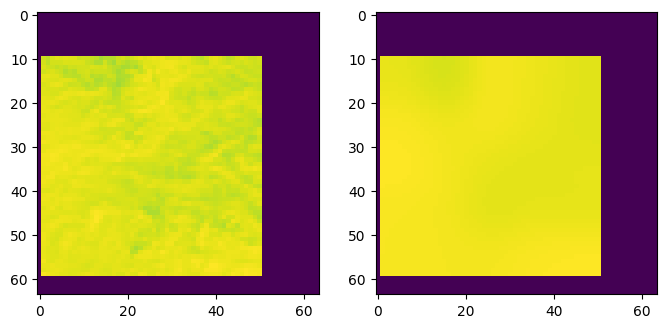

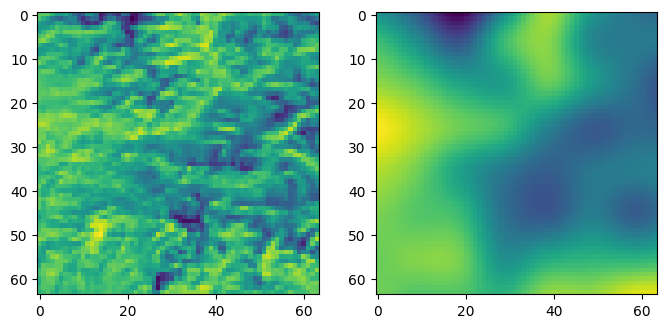

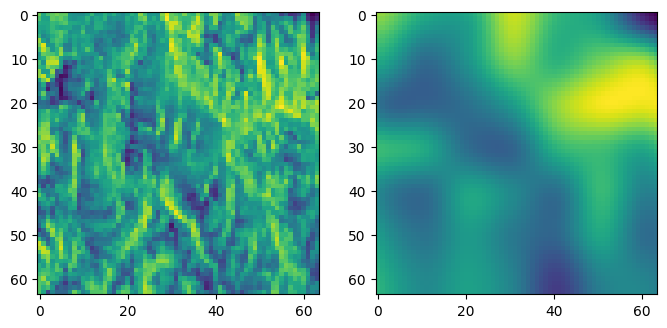

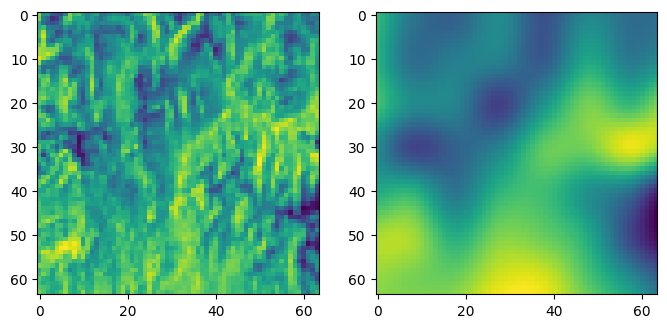

In [ ]:
class DataSampler:
    def __init__(self, img, sr_factor, crop_size):
        """ img must be a torch tensor """

        self.c, self.h, self.w = img.shape
        self.img = img.reshape(1, self.c, self.h, self.w)
        self.sr_factor = sr_factor
        self.pairs = self.create_hr_lr_pairs()
        self.crop_size = crop_size

        sizes = np.float32([hr.shape[-2]*hr.shape[-1] / float(self.h * self.w) \
                            for hr, _ in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomCrop((self.crop_size, self.crop_size),
                                  pad_if_needed=True) ])

        self.degrees = [0., 90., 180., 270.]

    def rotate(self, tensor):
        angle = np.random.choice(self.degrees)
        return ttf.rotate(tensor, angle)

    def create_hr_lr_pairs(self):
        smaller_side, larger_side = min(self.h,self.w), max(self.h,self.w)
        factors = []
        for i in range(smaller_side//5, smaller_side+1):
            downsampled_smaller_side = i
            zoom = float(downsampled_smaller_side)/smaller_side
            downsampled_larger_side = round(larger_side*zoom)
            if downsampled_smaller_side%self.sr_factor==0 and \
                downsampled_larger_side%self.sr_factor==0:
                factors.append(zoom)

        pairs = []
        for zoom in factors:
            hr = interpolate(self.img, scale_factor=zoom, mode="bicubic", antialias=True)
            lr = interpolate(hr, scale_factor=1/self.sr_factor, mode="bicubic", antialias=True)
            lr = interpolate(lr, scale_factor=self.sr_factor, mode="bicubic", antialias=True)
            pairs.append((hr, lr))

        return pairs

    def force_patch_size(self, tensor):
        _,_,h,w = tensor.shape
        target_crop = (self.crop_size, self.crop_size)
        if (h, w) != target_crop :
            # Consider to use nearest
            tensor = interpolate(tensor, size=target_crop, mode="bicubic", antialias=True)
        return tensor

    def generate_data(self):
        while True:
            hr, lr = random.choices(self.pairs, weights=self.pair_probabilities, k=1)[0]
            pair = torch.cat([hr, lr], 0)
            pair = self.transform(pair)
            pair = self.rotate(pair)
            pair = self.force_patch_size(pair)
            hr_tensor = pair[0, :, :, :].unsqueeze(0)
            lr_tensor = pair[1, :, :, :].unsqueeze(0)
            yield hr_tensor, lr_tensor


def read_h5_temperature(filename):
    """ Return torch tensor"""
    #Open the H5 file in read mode
    with h5File(filename, 'r') as f:
        tmp = torch.Tensor(f["Temperature"]["Mean"]).unsqueeze(0)
        tmp = torch.where(tmp==-9999, tmp[tmp!=0].mean(), tmp)
        tmp = tmp * 0.01
        tmp = tmp / tmp.max()
        return tmp

if __name__=="__main__":

    filenameimg = "alligator.jpg"
    #img = ttf.to_tensor(PIL.Image.open(filenameimg).convert("RGB").resize((400, 400)))

    filenameLR = "AG1km.v003.45.006.0010.h5"
    filenameHR = "AG100.v003.45.006.0001.h5"
    img = read_h5_temperature(filenameLR)

    sampler = DataSampler(img, sr_factor=10, crop_size=64)

    c = 0
    while c<10:
        hr, lr = sampler.generate_data().__next__()
        print(hr.shape, lr.shape)
        _,axs = plt.subplots(1, 2, figsize=(8,5))
        axs[0].imshow((hr.squeeze()))
        axs[1].imshow((lr.squeeze()))
        c+=1

### DataSampler, Batch implementation

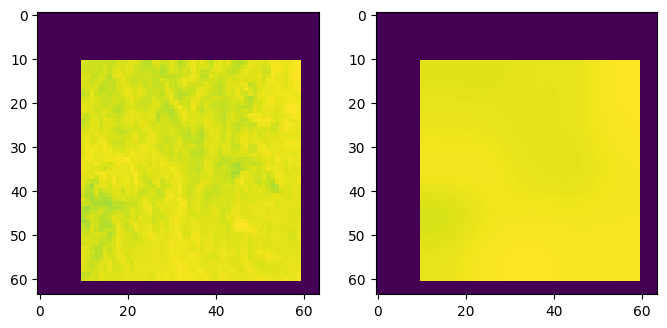

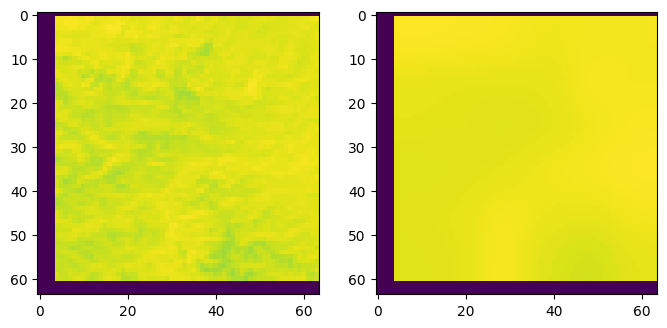

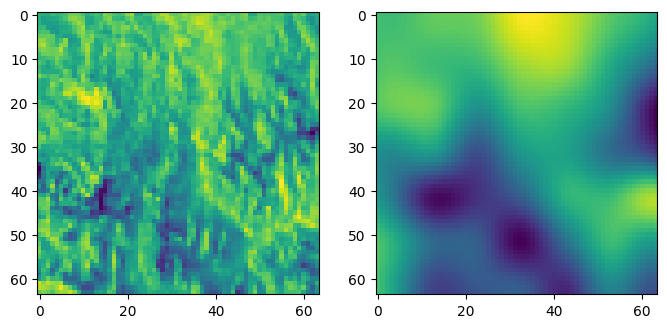

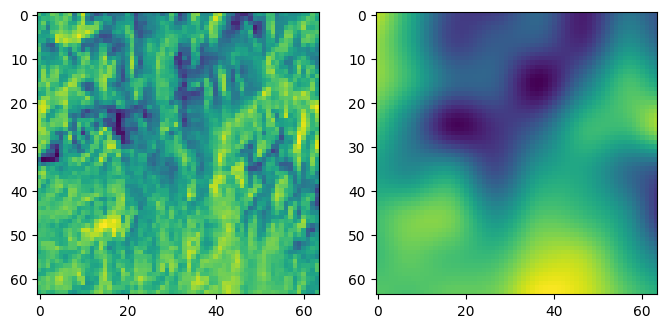

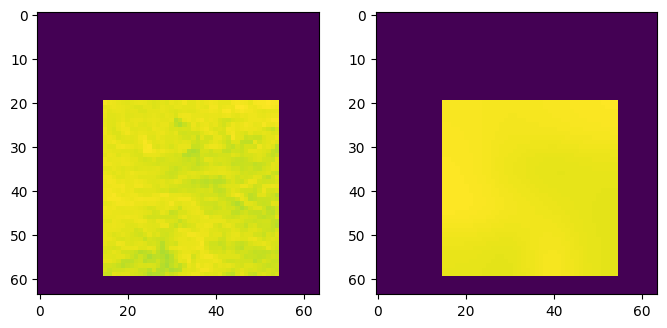

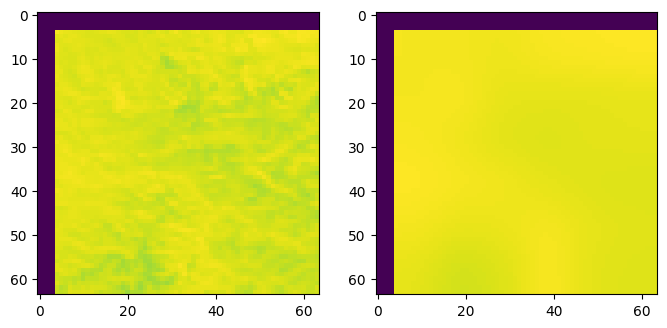

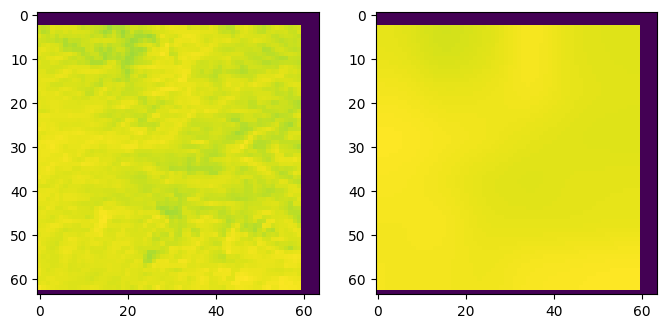

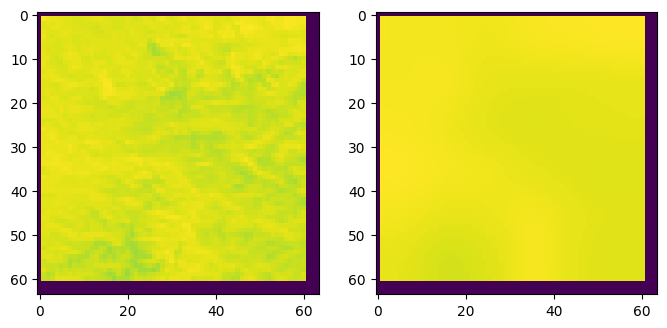

In [ ]:
class DataSamplerBatch:
    def __init__(self, img, sr_factor, crop_size, batch_size):
        """ img must be a torch tensor """

        self.c, self.h, self.w = img.shape
        self.img = img.reshape(1, self.c, self.h, self.w)
        self.sr_factor = sr_factor
        self.pairs = self.create_hr_lr_pairs()
        self.crop_size = crop_size
        self.batch_size = batch_size

        sizes = np.float32([hr.shape[-2]*hr.shape[-1] / float(self.h * self.w) \
                            for hr, _ in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomCrop((self.crop_size, self.crop_size),
                                  pad_if_needed=True) ])

        self.degrees = [0., 90., 180., 270.]

    def rotate(self, tensor):
        angle = np.random.choice(self.degrees)
        return ttf.rotate(tensor, angle)

    def create_hr_lr_pairs(self):
        smaller_side, larger_side = min(self.h,self.w), max(self.h,self.w)
        factors = []
        for i in range(smaller_side//5, smaller_side+1):
            downsampled_smaller_side = i
            zoom = float(downsampled_smaller_side)/smaller_side
            downsampled_larger_side = round(larger_side*zoom)
            if downsampled_smaller_side%self.sr_factor==0 and \
                downsampled_larger_side%self.sr_factor==0:
                factors.append(zoom)

        pairs = []
        for zoom in factors:
            hr = interpolate(self.img, scale_factor=zoom, mode="bicubic", antialias=True)
            lr = interpolate(hr, scale_factor=1/self.sr_factor, mode="bicubic", antialias=True)
            lr = interpolate(lr, scale_factor=self.sr_factor, mode="bicubic", antialias=True)
            pairs.append((hr, lr))

        return pairs

    def force_patch_size(self, tensor):
        _,_,h,w = tensor.shape
        target_crop = (self.crop_size, self.crop_size)
        if (h, w) != target_crop :
            # Consider to use nearest
            tensor = interpolate(tensor, size=target_crop, mode="bicubic", antialias=True)
        return tensor

    def generate_data(self):
        """ Return batch of sampled data """
        while True:
            # List of pairs
            batch = [] # or torch .zeros
            pairs = [torch.cat([hr, lr], 0) for hr, lr in \
                     random.choices(self.pairs, weights=self.pair_probabilities,
                     k=self.batch_size)]

            for pair in pairs:
                pair = self.transform(pair)
                pair = self.rotate(pair)
                pair = self.force_patch_size(pair)
                batch.append(pair.unsqueeze(0))

            batch = torch.cat(batch, 0)
            hr_tensor = batch[:, 0, :, :, :]
            lr_tensor = batch[:, 1, :, :, :]
            yield hr_tensor, lr_tensor


if __name__=="__main__":

    BATCH_SIZE = 8

    #filenameimg = "alligator.jpg"
    #img = ttf.to_tensor(PIL.Image.open(filenameimg).convert("RGB").resize((400, 400)))

    filenameLR = "AG1km.v003.45.006.0010.h5"
    filenameHR = "AG100.v003.45.006.0001.h5"
    img = read_h5_temperature(filenameLR)

    sampler = DataSamplerBatch(img, sr_factor=10, crop_size=64, batch_size=BATCH_SIZE)
    s = sampler.generate_data()
    hr, lr = s.__next__()

    for i in range(BATCH_SIZE):
        _,axs = plt.subplots(1, 2, figsize=(8,5))
        axs[0].imshow((hr[i, :,:,:].squeeze()))
        axs[1].imshow((lr[i, :,:,:].squeeze()))


### Self-supervised training

100%|██████████| 2000/2000 [06:13<00:00,  5.36it/s, Iteration: 2000/2000 lr: 1e-05 Loss « 0.0174568426 »]


Done training.
Bicubic - MAE: 0.02879178151488304, PSNR: 30.1456298828125
   ZSSR - MAE: 0.0263980720192194, PSNR: 30.723236083984375


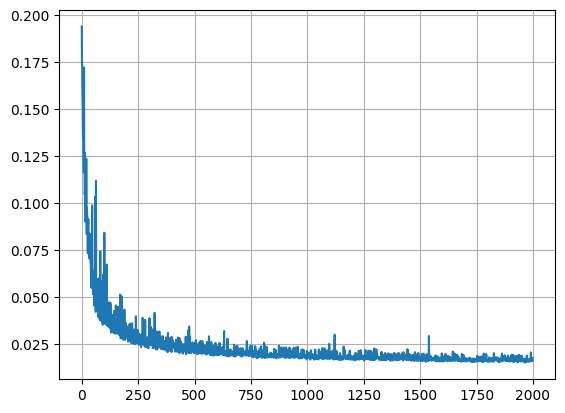

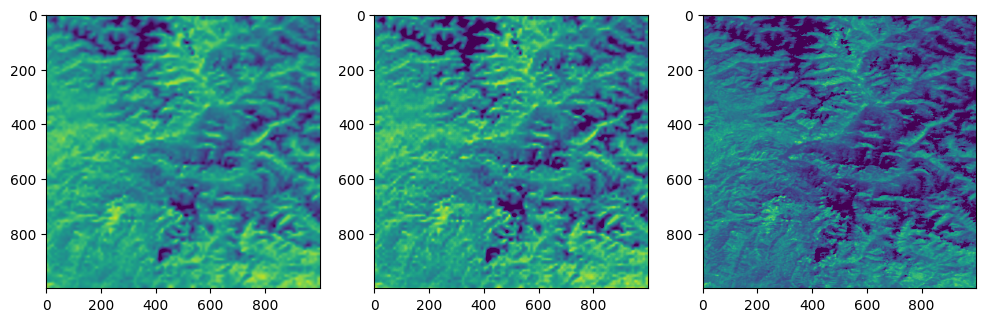

In [ ]:
from torch.autograd import Variable
from tqdm import tqdm

# Remove ---
def force_patch_size(hr, lr, crop_size):
    _,_,h,w = lr.shape
    if (h, w) != (crop_size, crop_size):
        lr = ttf.resize(lr, size=(crop_size, crop_size),
                        interpolation=PIL.Image.BICUBIC)
        hr = ttf.resize(hr, size=(crop_size, crop_size),
                        interpolation=PIL.Image.BICUBIC)
    return hr, lr
# Remove ---

def train(model, img, sr_factor, num_batches, learning_rate, crop_size,
          batch_size=None, reduce_epoch=10000, reduce_sf=0.001):

    # Model specs initialization
    loss = torch.nn.L1Loss()
    #loss = PSNR()

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    if batch_size:
        sampler = DataSamplerBatch(img, sr_factor, crop_size, batch_size)
    else:
        sampler = DataSampler(img, sr_factor, crop_size)

    model.train()
    progress_bar = tqdm(range(num_batches), total=num_batches)
    cache = torch.zeros(num_batches)
    for iteration in progress_bar:
        # Sampling a lr-hr pair
        hr, lr = sampler.generate_data().__next__()

        # Force same dimension random cropping
        #hr, lr = force_patch_size(hr, lr, crop_size)

        # To device
        lr, hr = lr.to(DEVICE), hr.to(DEVICE)

        # Residual mapping (if not implemented by default)
        output = model(lr) # + lr
        error = loss(output, hr)

        if iteration > 0 and iteration % reduce_epoch == 0:
            learning_rate = learning_rate * reduce_sf
            adjust_learning_rate(optimizer, new_lr=learning_rate)
            print("\nLearning rate reduced to {lr}".format(lr=learning_rate) )

        progress_bar.set_postfix_str(f"Iteration: {iteration+1}/{num_batches} lr: {learning_rate} Loss « {(error.item()):.10f} »")
        error.backward()
        optimizer.step()
        optimizer.zero_grad()
        cache[iteration] = error.item()

    print("Done training.")
    return cache

def test(model, img, sr_factor):
    """ Not so reliable"""
    img = interpolate(img, scale_factor=sr_factor, mode="bicubic", antialias=True)
    model.eval()
    with torch.no_grad():
        #img = transforms.ToTensor()(img)
        #img = torch.unsqueeze(img, 0)
        input = img.to(DEVICE)

        # If no residual mapping
        #residual = model(input)
        #output = input + residual
        output = model(input)
    output = output.cpu().data[0, :, :, :]
    o = output.numpy()
    o[np.where(o < 0)] = 0.0
    o[np.where(o > 1)] = 1.0
    output = torch.from_numpy(o)
    output = transforms.ToPILImage()(output)
    return output

def test(model, img, sr_factor):
    """ Perform ZS SR considering a new SR factor:
    Args:
        model: (torch.nn.Module) currently self-supervised trained model
        img: (torch.Tensor)
        sr_factor: (int)
    Return:
        SR inference, original img (bicubic upsampled)
    """
    img_up = img.unsqueeze(0) if len(img.shape) < 4 else img
    img_up = interpolate(img_up, scale_factor=sr_factor, mode="bicubic", antialias=True)\
             .to(DEVICE)

    model.eval()
    with torch.no_grad():
        inference = model(img_up)
    return inference, img_up


if __name__=="__main__":

    UP_SCALE = 10
    NUM_ITER = 2000
    LEARN_RATE = 1e-5
    CROP_SIZE = 64
    BATCH_SIZE = 16 # None for stochastic Update

    mae = torch.nn.L1Loss()

    filaneme = "alligator.jpg"
    #ground_truth = PIL.Image.open(filaneme).convert("RGB").resize((800,800))
    #img = ground_truth.resize((100,100), resample=PIL.Image.BICUBIC)

    filenameLR = "AG1km.v003.45.006.0010.h5"
    filanameHR = "AG100.v003.45.006.0001.h5"
    ground_truth = read_h5_temperature(filanameHR).to(DEVICE)
    img          = read_h5_temperature(filenameLR).to(DEVICE)
    llim, ulim = (img.mean()-3*img.std()).item(), (img.mean()+3*img.std()).item()
    channels = 1

    # ZSSRNet (e2000, lr1e-5, cs64, bs16)
    model = MRUNet(n_channels=channels, n_resblocks=4).to(DEVICE)
    #model   = ZSSRNet(input_channels=channels, kernel_size=3, channels=128, ndepth=(16-2)).to(DEVICE)
    history = train(model, img, sr_factor=UP_SCALE, num_batches=NUM_ITER,
                    learning_rate=LEARN_RATE, crop_size=CROP_SIZE,
                    batch_size=BATCH_SIZE)
    srimg, img_up  = test(model, img, sr_factor=UP_SCALE)

    # Print performance
    print(f"Bicubic - MAE: {mae(img_up, ground_truth)}, PSNR: {-psnr(img_up, ground_truth)}")
    print(f"   ZSSR - MAE: {mae(srimg, ground_truth)}, PSNR: {-psnr(srimg, ground_truth)}")


    # Plot
    plt.plot(history); plt.grid(); plt.show()

    # Add PSNR and SSIM plot


    _, axs = plt.subplots(1, 3, figsize=(12, 8))
    for i,item in enumerate((img_up, srimg, ground_truth)):
        axs[i].imshow(item.cpu().squeeze(), vmin=llim, vmax=ulim)
    plt.show()


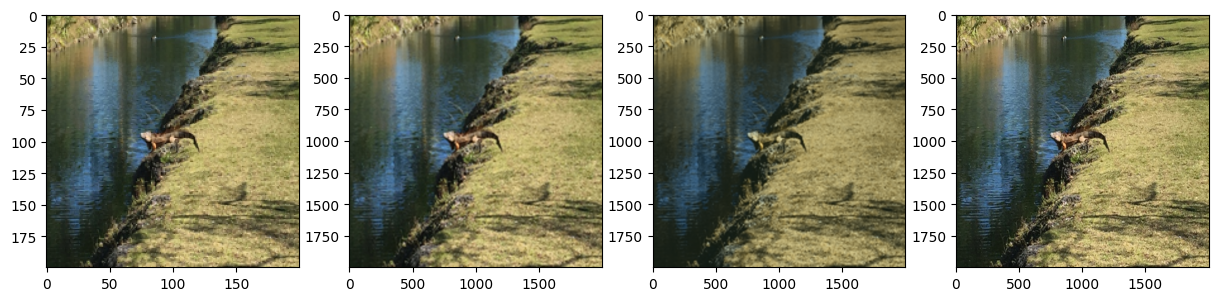

0.031022921204566956 tensor(74.9561)
0.06391724199056625 tensor(70.2877)


In [ ]:
UP_SCALE = 10
ground_truth = PIL.Image.open("alligator.jpg").convert("RGB").resize((2000,2000))
resized = img.resize((img.size[0]*UP_SCALE, img.size[1]*UP_SCALE), resample=PIL.Image.BICUBIC)
resized_tensor = ttf.to_tensor(resized).unsqueeze(0).to(DEVICE)

model.eval()
with torch.no_grad():
    srimage = model(resized_tensor)

srimage = ttf.to_pil_image(srimage.squeeze())

_,axs = plt.subplots(1,4,figsize=(15, 10))
axs[0].imshow(img)
axs[1].imshow(resized)
axs[2].imshow(srimage)
axs[3].imshow(ground_truth)
plt.show()

# Evaluation metrics
l1loss = torch.nn.L1Loss()
psnrloss = PSNR()
print(l1loss(resized_tensor.to("cpu"), ttf.to_tensor(ground_truth)).item(), -1*psnrloss(resized_tensor.to("cpu"), ttf.to_tensor(ground_truth)))
print(l1loss(ttf.to_tensor(srimage), ttf.to_tensor(ground_truth)).item(), -1*psnrloss(ttf.to_tensor(srimage), ttf.to_tensor(ground_truth)))

### Frequency filtering


In [ ]:
import numpy as np
def freq_mask(h,w,s, freq="low"):
    """
    Compute mask estimation according to either "low" or "high"
    frequency pass.
    Args:
        h,w: (int) hight and width image size
        s: (int) filter threshold
        freq: (str) "low" or "high" filter
    Return:
        torch.Tensor binary mask
    """
    xc = np.where(abs(np.arange(0, w)-(w/2)) <= s/2, 1, 0)  if freq=="low" \
        else  np.where(abs(np.arange(0, w)-(w/2)) <= (min(h,w)-s)/2, 0, 1)
    yc = np.where(abs(np.arange(0, h)-(h/2)) <= s/2, 1, 0)  if freq=="low" \
        else  np.where(abs(np.arange(0, h)-(h/2)) <= (min(h,w)-s)/2, 0, 1)
    return yc.reshape((yc.shape[0],1)).dot(xc.reshape((1,xc.shape[0])))

def freq_filter(img, h,w,s, freq="low"):
    """
    Return the preprocessed frequency map image according to either
    "low" or "high" frequency pass.
    Args:
        img: (torch.tensor) input image
        h,w: (int) hight and width image size
        s: (int) filter threshold
        freq: (str) "low" or "high" filter
    Return:
        torch.Tensor
    """
    img = torch.cat([img.unsqueeze(0) for i in range(3)], 0)
    return torch.tensor(abs(np.fft.ifft2(np.multiply(freq_mask(h,w,s,freq),
                                                    np.fft.fftshift(np.fft.fft2(img))
                                                    ))))[0,:,:]

In [ ]:
# Load MODIS dataset
from pyhdf.SD import SD, SDC
import h5py

filename = "AG1km.v003.45.007.0010.h5"

def read_h5_temperature(filename):
    """ Return torch tensor"""
    #Open the H5 file in read mode
    with h5py.File(filename, 'r') as f:
        tmp = torch.Tensor(f["Temperature"]["Mean"])
        tmp = torch.where(tmp==-9999, tmp[tmp!=0].mean(), tmp)
        tmp = tmp * 0.01
        tmp = tmp/tmp.max()
        return tmp
        #return tmp.reshape(1, 1, tmp.shape[-2], tmp.shape[-1])


# HR image reading and rescaling values by sf=0.02 (in K)
#data = SD(os.path.join(filename), SDC.READ)
#data = data.select("LST_Day_1km")[:,:].astype(np.float64)
#data = torch.Tensor(data*0.02)
#data = torch.where(data==0, data[data!=0].mean().item(), data)
data = read_h5_temperature(filename).squeeze()


h,w = 1200, 1200
factor = 0.2      # how much s needs to be reweighted (0=none,1=full)
s      = h * factor   # freq filter size
freq   = "high"       # "low" or "high" pass filtering

#freq_filt_img = freq_filter(data, h, w, s, freq)
#data = PIL.Image.open("alligator.jpg").convert("L").resize((1000,1000))
#data = ttf.to_tensor(data).squeeze()
coeffs_photo = pywt.wavedec2(data, 'db1', level=1)
cA_photo, (cH_photo, cV_photo, cD_photo) = coeffs_photo
sum_photo = torch.abs(torch.Tensor((cH_photo + cV_photo)).unsqueeze(0).unsqueeze(0))
sum_photo = interpolate(sum_photo, scale_factor=2, mode="bicubic", antialias=True)

_, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].imshow(data)
axs[1].imshow(sum_photo.squeeze() , cmap="gray")


---

# Custom implementation

### Custom DataSampler implementation 1st attempt


In [ ]:
class DataSampler:
    def __init__(self, img, sr_factor, crop_size, batch_size=8, nchannels=3):
        self.img = img
        self.nchannels = nchannels
        self.crop_size = crop_size
        self.sr_factor = sr_factor
        self.batch_size = batch_size
        self.pairs = self.create_hr_lr_pairs()
        sizes = np.float32([x[0].size[0]*x[0].size[1] / float(img.size[0]*img.size[1]) \
            for x in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

        self.transform = transforms.Compose([
            RandomRotationFromSequence([0., 90., 180., 270.]),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            RandomCrop((crop_size, crop_size)),
            ToTensor()])

        self.resize = transforms.Resize(size = (crop_size, crop_size))

    def create_hr_lr_pairs(self):
        smaller_side = min(self.img.size[0 : 2])
        larger_side = max(self.img.size[0 : 2])

        factors = []
        for i in range(smaller_side//5, smaller_side+1):
            downsampled_smaller_side = i
            zoom = float(downsampled_smaller_side)/smaller_side
            downsampled_larger_side = round(larger_side*zoom)
            if downsampled_smaller_side%self.sr_factor==0 and \
                downsampled_larger_side%self.sr_factor==0:
                factors.append(zoom)

        pairs = []
        for zoom in factors:
            hr = self.img.resize((int(self.img.size[0]*zoom), \
                                int(self.img.size[1]*zoom)), \
                resample=PIL.Image.BICUBIC)

            lr = hr.resize((int(hr.size[0]/self.sr_factor), \
                int(hr.size[1]/self.sr_factor)),
                resample=PIL.Image.BICUBIC)

            lr = lr.resize(hr.size, resample=PIL.Image.BICUBIC)

            pairs.append((hr, lr))

        return pairs

    def sample_pair(self):
        """ Return a single {hr-lr} pair
        """
        while True:
            hr, lr = random.choices(self.pairs, weights=self.pair_probabilities, k=1)[0]
            hr_tensor, lr_tensor = self.transform((hr, lr))
            hr_tensor = torch.unsqueeze(hr_tensor, 0)
            lr_tensor = torch.unsqueeze(lr_tensor, 0)
            yield hr_tensor, lr_tensor

    def check_dimension(self, tensor):
        """ Ensuring sub-patches to repsect crop size dimension
        """
        c, h, w = (self.nchannels, self.crop_size, self.crop_size)
        if tensor.shape != (c, h, w):
           tensor = self.resize(tensor)
        return tensor

    def generate_data(self):
        """ Yield a batch of {hr-lr} pairs
        Return
            hr: torch.Tensor of dim: (batch_size, n_channels, H, W)
            lr: torch.Tensor of dim: (batch_size, n_channels, H, W)
        """
        while True:
            batch = random.choices(self.pairs, weights=self.pair_probabilities, k=self.batch_size)
            batch = [self.transform((hr, lr)) for hr, lr in batch]
            hr_tensor = torch.cat([self.check_dimension(hr).unsqueeze(0) for hr, _ in batch], 0)
            lr_tensor = torch.cat([self.check_dimension(lr).unsqueeze(0) for _, lr in batch], 0)
            yield hr_tensor, lr_tensor

UP_SCALE = 4
PATCH_SIZE = 50
BATCH_SIZE = 8

img = PIL.Image.open("alligator.jpg")
sampler = DataSampler(img,
                        sr_factor=UP_SCALE,
                        crop_size=PATCH_SIZE,
                      batch_size=BATCH_SIZE)

# Perform Self-supervised training

In [ ]:
from torch.autograd import Variable
from tqdm import tqdm

def train(model, img, sr_factor=4, num_batches=100, learning_rate=0.0001,
          crop_size=64, batch_size=8):

    # Model specs initialization
    loss = torch.nn.L1Loss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    sampler = DataSampler(img, sr_factor, crop_size, batch_size)

    model.train()
    progress_bar = tqdm(range(num_batches), total=num_batches)

    for iteration in progress_bar:
        hr, lr = sampler.generate_data().__next__()

        lr = lr.cuda()
        hr = hr.cuda()

        # Residual mapping (if not implemented by default)
        output = model(lr) # + lr
        error = loss(output, hr)

        if iteration > 0 and iteration % 1000 == 0:
            learning_rate = learning_rate / 10
            adjust_learning_rate(optimizer, new_lr=learning_rate)
            print("\nLearning rate reduced to {lr}".format(lr=learning_rate) )

        progress_bar.set_postfix_str(f"Iteration: {iteration}/{num_batches} lr: {learning_rate} Loss « {(error.item()):.10f} »")

        error.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Done training.")


def test(model, img, sr_factor):
    model.eval()

    img = img.resize((int(img.size[0]*sr_factor), \
        int(img.size[1]*sr_factor)), resample=PIL.Image.BICUBIC)
    #img.save('low_res.png')

    with torch.no_grad():
        img = transforms.ToTensor()(img)
        img = torch.unsqueeze(img, 0)
        input = Variable(img.to(DEVICE))
        residual = model(input)
        output = input + residual

    output = output.cpu().data[0, :, :, :]
    o = output.numpy()
    o[np.where(o < 0)] = 0.0
    o[np.where(o > 1)] = 1.0
    output = torch.from_numpy(o)
    output = transforms.ToPILImage()(output)

    return output
    #output.save('zssr.png')

In [ ]:
# Hyperparams
UP_SCALE = 4
PATCH_SIZE = 50
NUM_BATCHES = 1000
BATCH_SIZE = 32
LEARNING_RATE = 1e-6

# Load img
hr_img = PIL.Image.open("alligator.jpg").convert("RGB").resize((200,200))
lr_img = hr_img.resize((50,50))

hr = ttf.to_tensor(hr_img).unsqueeze(0)
lr = ttf.to_tensor(lr_img).unsqueeze(0)

# Model init
#model = ZSSRNet(input_channels=3, kernel_size=3, channels=64, ndepth=8).to(DEVICE)
model = MRUNet(n_channels=3, n_resblocks=1).to(DEVICE)
loss_function = torch.nn.L1Loss()

# Train
train(model, hr_img, sr_factor=UP_SCALE, num_batches=NUM_BATCHES,
      learning_rate=LEARNING_RATE, crop_size=PATCH_SIZE,
      batch_size=BATCH_SIZE)

# Inference
#output = test(model, img, sr_factor = UP_SCALE)

# bicubic interpolation
img_up = interpolate(ttf.to_tensor(img).unsqueeze(0),
                     scale_factor=UP_SCALE, mode="bicubic", antialias=True)
model.eval()
with torch.no_grad():
    inference = model(ttf.to_tensor(img).to(DEVICE))


# Eval performance
x, y = img_up, ttf.to_tensor(orig).unsqueeze(0)
print("Bicubic vs Orig:", loss_function(x,y).item(), psnr(x, y))#, ssim(x, y))
x, y = ttf.to_tensor(output).unsqueeze(0), ttf.to_tensor(orig).unsqueeze(0)
print("ZSSR vs Orig:   ", loss_function(x,y).item(), psnr(x, y))#, ssim(x, y))


# Plot
_, axs = plt.subplots(1,4,figsize=(14, 8))
axs[0].imshow(img); axs[0].set_title(f"Input at {img.size}")
axs[1].imshow(ttf.to_pil_image(img_up.squeeze())); axs[1].set_title(f"Input bicubic at {orig.size}")
axs[2].imshow(output); axs[2].set_title(f"SR(Input) at {output.size}")
axs[3].imshow(orig); axs[3].set_title(f"Original at {orig.size}")
plt.tight_layout(); plt.show()

### Custom single image train
from $(50,50)$ to $(400,400)$ simple x4 scale factor to test whether $f_{\theta}$ outperforms bicubic interpolation


In [ ]:
# Hyperparams
UP_SCALE = 4
LEARNING_RATE = 1e-5

# Load img and rescale
orig = PIL.Image.open("alligator.jpg").convert("RGB").resize((200,200))
img =  orig.resize((50,50))
orig_tensor = ttf.to_tensor(orig).unsqueeze(0)
img_tensor = ttf.to_tensor(img).unsqueeze(0)

# To device
#img_tensor = interpolate(img_tensor, scale_factor=UP_SCALE, mode="bicubic", antialias=True)
lr = img_tensor.to(DEVICE)
hr = orig_tensor.to(DEVICE)
_, _, h, w = lr.shape

# Normalise
lr = lr / lr.max()
hr = hr / hr.max()

# Model init
#model = ZSSRNet(input_channels=3, kernel_size=3, channels=64, ndepth=6).to(DEVICE)
#model = MRUNet(n_channels=3, n_resblocks=16).to(DEVICE)

# Prepare Windowsize
window_size, upscale = h, UP_SCALE
height = (h // upscale // window_size + 1) * window_size
width  = (w // upscale // window_size + 1) * window_size
print(height, width)

model = SwinIR(upscale=UP_SCALE, img_size=(height, width),
                window_size=window_size, img_range=1., depths=[6, 6],
                embed_dim=60, num_heads=[6, 6], mlp_ratio=2,
                upsampler='pixelshuffle').to(DEVICE)

loss_function = torch.nn.L1Loss()
optimizer     = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler     = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode='min', factor=0.1, patience=20, threshold=0.00001,
                    threshold_mode='abs')

50 50


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100%|██████████| 500/500 [03:25<00:00,  2.43it/s, Epoch: 500/500 Loss « 0.02729445 »]



Bicubic vs Orig hr: MAE 0.08249010145664215 PSNR 67.86322021484375
ZSSR lr vs Orig hr: MAE 0.027294451370835304 PSNR 75.67140197753906


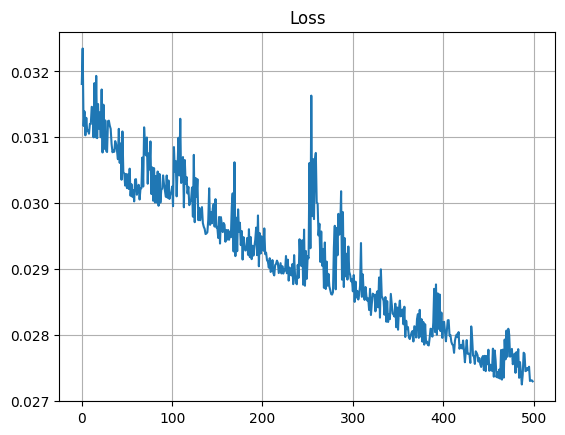

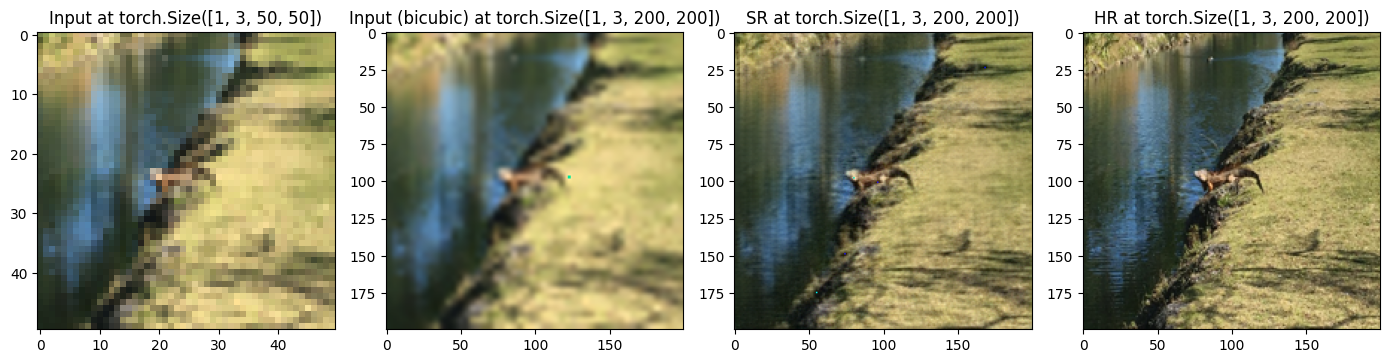

In [ ]:
NUM_EPOCHS = 500
adjust_learning_rate(optimizer, 1e-4)

# Train Loop
model.train()
progression_bar = tqdm(range(NUM_EPOCHS), total = NUM_EPOCHS)
cache = torch.zeros((NUM_EPOCHS))
for e in progression_bar:

    # MRUnet already implemented resiudual addition
    output = model(lr).to(DEVICE)
    loss = loss_function(output, hr)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #scheduler.step(loss.item())

    cache[e] = loss.item()
    progression_bar.set_postfix_str(f"Epoch: {e+1}/{NUM_EPOCHS} Loss « {(loss.item()):.8f} »")

# Performance
bicubic_lr =  interpolate(lr, scale_factor=UP_SCALE, mode="bicubic", antialias=True)
print("\nBicubic vs Orig hr:", "MAE", loss_function(bicubic_lr,hr).item(),"PSNR",psnr(bicubic_lr, hr))#, ssim(x, y))
print("ZSSR lr vs Orig hr:", "MAE", loss_function(output, hr).item(),"PSNR",psnr(output, hr))#, ssim(x, y))

#print(ssim(lr, hr), ssim(output, hr))

# Plot
plt.plot(cache); plt.title("Loss"); plt.grid(); plt.show()

_, axs = plt.subplots(1,4,figsize=(14, 8))
axs[0].imshow(ttf.to_pil_image(lr.squeeze())); axs[0].set_title(f"Input at {lr.shape}")
axs[1].imshow(ttf.to_pil_image(bicubic_lr.squeeze())); axs[1].set_title(f"Input (bicubic) at {bicubic_lr.shape}")
axs[2].imshow(ttf.to_pil_image(output.squeeze())); axs[2].set_title(f"SR at {output.shape}")
axs[3].imshow(ttf.to_pil_image(hr.squeeze())); axs[3].set_title(f"HR at {hr.shape}")
plt.tight_layout(); plt.show()

In [ ]:
#### Sliding window test to evaluate zero-shot performance vs bicubic (at least vsually)
#### try with ASTER with ground truth at x10 sf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Zero-shot super resolution by upsampling original hr to an arbitrary SF (bicubic).

---

# HFGN module
_(High Frequency Guided Framework)_ Network


In [ ]:
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.transforms.functional import rgb_to_grayscale
import pywt

class HFGM(torch.nn.Module):
    """High Frequency Guided Module"""
    def __init__(self, nchannels, ndim=16):
        super().__init__()
        self.nchannels = nchannels
        self.ndim = ndim
        self.d = torch.nn.Parameter(torch.abs(torch.randn(1, 1, 1, 1)))
        self.d.requires_grad = True

        self.convQ = torch.nn.Conv2d(1, ndim, kernel_size=3, stride=1, padding="same")
        self.convA = torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding="same")
        self.conv3 = torch.nn.Conv2d(nchannels, ndim, kernel_size=3, stride=1, padding="same")
        self.conv1 = torch.nn.Conv2d(ndim, nchannels, kernel_size=1, stride=1)

    def get_hf_components(self, x):
        # Must be convert into a single channel input
        # This should be different with rspect to x_features
        if self.nchannels == 1:
            _, (cH, cV, cD) = pywt.wavedec2(x, 'db1', level=1)
        elif self.nchannels == 3:
            _, (cH, cV, cD) = pywt.wavedec2(rgb_to_grayscale(x).squeeze(), 'db1', level=1)
        else:
            raise Exception(f"DWT Not implemented for {self.nchannels}.")

        csum = torch.abs(torch.Tensor([cH, cV, cD]).sum(0))
        return csum.view(1, 1, csum.shape[-2], csum.shape[-1]) # Check dim

    def forward(self, x):
        _, _, h, w = x.shape
        # Query
        x_up = torch.nn.functional.interpolate(x, scale_factor=2, mode="bilinear", antialias="True")
        q = self.get_hf_components(x_up)
        q = self.convQ(q).view(1, h*w, self.ndim)
        k = self.conv3(x).view(1, self.ndim, h*w)
        v = self.conv3(x).view(1, h*w, self.ndim)

        # Cross-attention map
        ca = (torch.matmul(k, q) / self.d**0.5)
        ca = self.convA(ca)
        ca = softmax(ca, -1)
        ca = torch.matmul(v, ca)
        ca = ca.view(1, self.ndim, h, w)
        ca = self.conv1(ca)
        return x + ca

if __name__=="__main__":

    nchannels = 1
    ndim = 128
    hfgm = HFGM(nchannels, ndim)

    x = torch.rand((1, nchannels, 64, 64))
    re = hfgm(x)
    print(x.shape, re.shape)

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])


In [ ]:
nchannels = 1
ndim = 128
hfgm = HFGM(nchannels, ndim)

x = torch.rand((1, nchannels, 64, 64))
re = hfgm(x)
re.shape

torch.Size([1, 1, 64, 64])

In [ ]:
# Backup test copy to debug the above module
nchannels = 1
ndim = 16
d = 4
hfgm = HFGM(nchannels, ndim)

x = torch.rand((1, nchannels, 64, 64))

conv1  = torch.nn.Conv2d(in_channels=ndim, out_channels=nchannels,
                        kernel_size=1, stride=1, padding="same")

convQK = torch.nn.Conv2d(in_channels=1, out_channels=1,
                        kernel_size=3, stride=1, padding="same")

q,k,v = hfgm(x)

print("QKV", q.shape, k.shape, v.shape)

ca = torch.matmul(k, q).unsqueeze(0)
print(ca.shape)

ca = convD(ca)
print(ca.shape)

ca = softmax(ca, -1)
print(ca.shape)

tmp = torch.matmul(v, ca)
print(tmp.shape)

tmp = tmp.reshape(1, ndim, 64, 64)
print(tmp.shape)
re = conv1(tmp)
print(re.shape)


QKV torch.Size([1, 4096, 16]) torch.Size([1, 16, 4096]) torch.Size([1, 4096, 16])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 4096, 16])
torch.Size([1, 16, 64, 64])
torch.Size([1, 1, 64, 64])


### Modified ZSSR


In [ ]:
# Adapted From: https://github.com/jacobgil/pytorch-zssr (Apache License)  @ jacobgil
import torch

class ZSSRNet(nn.Module):
	def __init__(self, input_channels=1, kernel_size=3, channels=64, ndepth=6, ndim=16):
		super(ZSSRNet, self).__init__()
		self.conv_i = torch.nn.Conv2d(input_channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
		self.conv   = torch.nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
		self.conv_f = torch.nn.Conv2d(channels, input_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
		self.relu = torch.nn.ReLU()
		self.ndepth = ndepth
        self.HFGM = HFGM(input_channels, ndim)

	def forward(self, x):
        hf_input = self.HFGM(x)
        x = self.relu(self.conv_i(x))
		for i in range(self.ndepth):
			x = self.relu(self.conv(x))
		x = self.conv_f(x)
		return x + hf_input # go on from here